In [31]:
# load normal image
train_NORMAL_dir <- '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/'
train_NORMAL <- list.files(train_NORMAL_dir)

test_image <- load.image(paste(train_NORMAL_dir, train_NORMAL[1], sep=''))
plot(test_image)

NameError: name 'train_NORMAL_dir' is not defined

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:23<00:00, 84.8MB/s]
100% 2.29G/2.29G [00:23<00:00, 106MB/s] 


In [20]:
import cv2
import os
import numpy as np

def load_and_preprocess_data(base_path, img_size=64):
    X = []
    Y = []
    # Definimos las categorías
    categories = ['NORMAL', 'PNEUMONIA']

    for category in categories:
        path = os.path.join(base_path, category)
        class_num = categories.index(category) # 0 para Normal, 1 para Pneumonia

        # Listamos los archivos en la carpeta
        for img in os.listdir(path):
            try:
                # Leer imagen en color
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path)

                # Redimensionar para que todas sean iguales
                resized_array = cv2.resize(img_array, (img_size, img_size))

                X.append(resized_array)
                Y.append(class_num)
            except Exception as e:
                # Por si hay algún archivo corrupto
                pass

    # Convertir a arreglos de numpy
    X = np.array(X)
    Y = np.array(Y).reshape(1, -1) # Forma (1, m)

    # Aplanar las imágenes: de (m, 64, 64, 3) a (64*64*3, m)
    X_flatten = X.reshape(X.shape[0], -1).T

    # Dividimos por 255 para que los valores estén entre 0 y 1
    X_norm = X_flatten / 255.

    return X_norm, Y

# --- EJECUCIÓN ---
print("Cargando datos de entrenamiento...")
train_set_x, train_set_y = load_and_preprocess_data('chest_xray/train')

print("Cargando datos de prueba...")
test_set_x, test_set_y = load_and_preprocess_data('chest_xray/test')

print(f"Entrenamiento: {train_set_x.shape}")
print(f"Pruebas: {test_set_x.shape}")

Cargando datos de entrenamiento...
Cargando datos de prueba...
Entrenamiento: (12288, 5216)
Pruebas: (12288, 624)


#Funciones de Activación

In [ ]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###

    return s

In [ ]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


In [ ]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros(shape=(dim, 1))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

In [ ]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


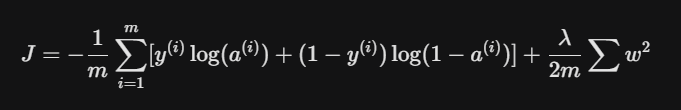

In [ ]:
def propagate(w, b, X, Y, lambd = 0.1): # Agregamos el parámetro lambd (lambda)
    m = X.shape[1]

    # FORWARD PROPAGATION
    A = sigmoid(np.dot(w.T, X) + b)

    # COSTO MODIFICADO: Agregamos el término de regularización L2
    cross_entropy_cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))
    l2_regularization_cost = (lambd / (2 * m)) * np.sum(np.square(w)) # <--- ESTO ES LO NUEVO

    cost = cross_entropy_cost + l2_regularization_cost

    # BACKWARD PROPAGATION
    # También debemos ajustar el gradiente de w (dw) con la derivada de la regularización
    dw = (1 / m) * np.dot(X, (A - Y).T) + (lambd / m) * w # <--- ESTO ES LO NUEVO
    db = (1 / m) * np.sum(A - Y)

    grads = {"dw": dw, "db": db}
    return grads, np.squeeze(cost)

In [ ]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[1.04993216]
 [2.09980262]]
db = 0.49993523062470574
cost = 6.000064773192205


In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """

    costs = []

    for i in range(num_iterations):


        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ###
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw  # need to broadcast
        b = b - learning_rate * db
        ### END CODE HERE ###

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [ ]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.09054147]
 [0.1881324 ]]
b = 1.5609891822095645
dw = [[0.8876314 ]
 [1.72896005]]
db = 0.41803525218933824


In [ ]:

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###

    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
        ### END CODE HERE ###

    assert(Y_prediction.shape == (1, m))

    return Y_prediction

In [ ]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


In [ ]:

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [ ]:
learning_rates = [0.1, 0.01, 0.005, 0.001, 0.0001]

models = {}

for lr in learning_rates:
    print("Learning rate:", lr)

    models[str(lr)] = model(
        train_set_x,
        train_set_y,
        test_set_x,
        test_set_y,
        num_iterations=2000,
        learning_rate=lr,
        print_cost=True
    )

    print("\n-----------------------------\n")

Learning rate: 0.1
Cost after iteration 0: 0.693147


/tmp/ipython-input-1928763320.py:8: RuntimeWarning: divide by zero encountered in log
  cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # compute cost
/tmp/ipython-input-1928763320.py:8: RuntimeWarning: invalid value encountered in multiply
  cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # compute cost


Cost after iteration 100: nan
Cost after iteration 200: nan
Cost after iteration 300: nan
Cost after iteration 400: nan
Cost after iteration 500: nan
Cost after iteration 600: nan
Cost after iteration 700: nan
Cost after iteration 800: nan
Cost after iteration 900: nan
Cost after iteration 1000: nan
Cost after iteration 1100: nan
Cost after iteration 1200: nan
Cost after iteration 1300: nan
Cost after iteration 1400: nan
Cost after iteration 1500: nan
Cost after iteration 1600: nan
Cost after iteration 1700: nan
Cost after iteration 1800: nan
Cost after iteration 1900: nan
train accuracy: 96.4532208588957 %
test accuracy: 72.59615384615384 %

-----------------------------

Learning rate: 0.01
Cost after iteration 0: 0.693147
Cost after iteration 100: 1.129004
Cost after iteration 200: 0.190605
Cost after iteration 300: 0.153113
Cost after iteration 400: 0.142468
Cost after iteration 500: 0.136126
Cost after iteration 600: 0.131532
Cost after iteration 700: 0.127890
Cost after iteration

KeyError: 'train_accuracy'

#Volver a probar con Probit

In [21]:
import numpy as np
from math import erf

def probit(z):
    z = np.array(z)
    return 0.5 * (1 + np.vectorize(erf)(z / np.sqrt(2)))

In [22]:
def normal_pdf(z):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2)


In [23]:
def propagate(w, b, X, Y):

    m = X.shape[1]  # número de ejemplos

    # =========================
    # FORWARD PROPAGATION
    # =========================

    # 1. Combinación lineal
    Z = np.dot(w.T, X) + b

    # 2. Activación PROBIT
    A = probit(Z)

    # =========================
    # COSTO: MSE
    # =========================

    cost = (1 / (2 * m)) * np.sum((A - Y) ** 2)


    # =========================
    # BACKWARD PROPAGATION
    # =========================

    # Para MSE + probit:
    # dZ = (A - Y) * dA/dZ
    # y dA/dZ en probit es la PDF normal φ(Z)

    dZ = (A - Y) * normal_pdf(Z)

    dw = (1 / m) * np.dot(X, dZ.T)
    db = (1 / m) * np.sum(dZ)


    # =========================
    # AJUSTES
    # =========================

    assert(dw.shape == w.shape)
    cost = np.squeeze(cost)

    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [24]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[2.14638374e-32]
 [4.29276747e-32]]
db = 1.0731918678315302e-32
cost = 0.25


In [25]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """

    costs = []

    for i in range(num_iterations):


        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ###
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw  # need to broadcast
        b = b - learning_rate * db
        ### END CODE HERE ###

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [26]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[1.]
 [2.]]
b = 2.0
dw = [[2.14638374e-32]
 [4.29276747e-32]]
db = 1.0731918678315302e-32


In [27]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Activación PROBIT
    Z = np.dot(w.T, X) + b
    A = probit(Z)

    # Clasificación con umbral 0.5
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0

    assert(Y_prediction.shape == (1, m))

    return Y_prediction


In [28]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


In [29]:

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [30]:
learning_rates = [0.1, 0.01, 0.005, 0.001, 0.0001]

models = {}

for lr in learning_rates:
    print("Learning rate:", lr)

    models[str(lr)] = model(
        train_set_x,
        train_set_y,
        test_set_x,
        test_set_y,
        num_iterations=2000,
        learning_rate=lr,
        print_cost=True
    )

    print("\n-----------------------------\n")

Learning rate: 0.1
Cost after iteration 0: 0.125000
Cost after iteration 100: 0.128547
Cost after iteration 200: 0.128547
Cost after iteration 300: 0.128547
Cost after iteration 400: 0.128547
Cost after iteration 500: 0.128547
Cost after iteration 600: 0.128547
Cost after iteration 700: 0.128547
Cost after iteration 800: 0.128547
Cost after iteration 900: 0.128547
Cost after iteration 1000: 0.128547
Cost after iteration 1100: 0.128547
Cost after iteration 1200: 0.128547
Cost after iteration 1300: 0.128547
Cost after iteration 1400: 0.128547
Cost after iteration 1500: 0.128547
Cost after iteration 1600: 0.128547
Cost after iteration 1700: 0.128547
Cost after iteration 1800: 0.128547
Cost after iteration 1900: 0.128547
train accuracy: 74.29064417177915 %
test accuracy: 62.5 %

-----------------------------

Learning rate: 0.01
Cost after iteration 0: 0.125000
Cost after iteration 100: 0.128058
Cost after iteration 200: 0.092063
Cost after iteration 300: 0.039351
Cost after iteration 400: